In [2]:
import torch
import numpy as np

import random
import copy
import os
import pickle

import cl_gym as cl
from metrics import MetricCollector2, FairMetricCollector
from configs import make_params

EER_dataset = ["MNIST", "FashionMNIST", "CIFAR10", "CIFAR100"]

In [3]:
LOG_PATH = f"scripts_output"
OUT_PATH = f"outputs"

def is_number(value):
    flag=True
    try:
        num=float(value)
        flag = num == num
    except ValueError:
        flag=False
    return flag


def load(dataset, seed, epoch, lr, tau, alpha, lmbd, method, fair_metric, randinx = False, verbose=2):
    path = f"dataset={dataset}"
    if randinx:
        path+="_randidx"
    # if method != "FSW":
    #     fair_metric = "no_metrics"
    path = os.path.join(path, method)
    path = os.path.join(path, fair_metric)

    # Get log_path
    runs = list()
    for d in os.listdir(os.path.join(LOG_PATH, path)):
        info_dict = dict()
        info_dict['path'] = d
        # print(f"{d=}")
        for elem in d.split("_"):
            k, v = elem.split("=")
            info_dict[k] = int(v) if v.isdigit() else float(v) if is_number(v) else v
            info_dict['path'] = d
        runs.append(info_dict)
    avails = list()
    for run in runs:
        seed_flag = seed == run.get("seed", None)
        epoch_flag = epoch == run.get("epoch", None)
        lr_flag = lr == run.get("lr", None)
        tau_flag = tau == run.get("tau", 0)
        alpha_flag = alpha == run.get("alpha", 0)
        lmbd_flag = lmbd == run.get("lmbd", 0)
        flag = seed_flag & epoch_flag & lr_flag & tau_flag & alpha_flag & lmbd_flag
        if flag:
            avails.append(run)
    
    if len(avails) == 0:
        if verbose > 2:
            print(runs)
        return False
    target = avails[0]
    
    log_path = os.path.join(path, target['path'])

    out = os.path.join(os.path.join(LOG_PATH, log_path), "log.out")
    err = os.path.join(os.path.join(LOG_PATH, log_path), "log.err")
    if os.path.exists(err):
        with open(err, "r") as f:
            lines = f.readlines()
        if len(lines):
            if verbose:
                print(f"Error in {err} - error during running")
                for line in lines:
                    print(line)
            return False
    else:
        if verbose:
            print(f"error in {os.path.join(LOG_PATH, path)} - not exists")
        return False
    if os.path.exists(out):
        with open(out, "r") as f:
            lines = f.readlines()
        if len(lines) == 0:
            if verbose:
                print(f"{os.path.join(LOG_PATH, path)} - currently running")
            return False
        
    # Get out_path
    runs = list()
    for d in os.listdir(os.path.join(OUT_PATH, path)):
        info_dict = dict()
        info_dict['path'] = d
        # print(f"{d=}")
        for elem in d.split("_"):
            k, v = elem.split("=")
            info_dict[k] = int(v) if v.isdigit() else float(v) if is_number(v) else v
            info_dict['path'] = d
        runs.append(info_dict)

    avails = list()
    for run in runs:
        seed_flag = seed == run.get("seed", None)
        epoch_flag = epoch == run.get("epoch", None)
        lr_flag = lr == run.get("lr", None)
        tau_flag = tau == run.get("tau", 0)
        alpha_flag = alpha == run.get("alpha", 0)
        lmbd_flag = lmbd == run.get("lmbd", 0)
        flag = seed_flag & epoch_flag & lr_flag & tau_flag & alpha_flag & lmbd_flag
        if flag:
            avails.append(run)
    if len(avails) == 0:
        if verbose > 2:
            print(runs)
        return False
    target = avails[0]
    out_path = os.path.join(path, target['path'])
    return out_path

def print_log(path, option='err'):
    out = os.path.join(os.path.join(LOG_PATH, path), "log.out")
    err = os.path.join(os.path.join(LOG_PATH, path), "log.err")    
    if option == "err":
        if os.path.exists(err):
            with open(out, "r") as f:
                lines = f.readlines()
                print(lines)
    elif option == "out":
        if os.path.exists(out):
            with open(out, "r") as f:
                lines = f.readlines()
                print(lines)

def load_metrics(path, verbose=0):
    metrics_dir = os.path.join(os.path.join(OUT_PATH, path), "metrics/metrics.pickle")
    try:
        with open(metrics_dir, "rb") as f:
            metric_manager_callback = pickle.load(f)
    except:
        print(f"{path} still running")
        return -1

    if verbose>0:
        print(f"{metric_manager_callback.meters.keys()}")
    return metric_manager_callback

In [4]:
def get_best(dataset, seed_range, epoch, lr_range, tau_range, alpha_range, lambda_range, \
             method, randinx = False, verbose=1, metric=None):
    randinx = False
    acc_list = list()
    fair_list = list()
    info_list = list()
    if dataset in EER_dataset:
        disp_metric = "EER"
        disp_metric2 = "EER"
        metric = "EER"
    else:
        if metric is None or metric == "no_metrics":
            disp_metric = "EO"
            disp_metric2 = "DP"
        else:
            if metric == "EO":
                disp_metric = "EO"
                disp_metric2 = "DP"
            elif metric == "DP":
                disp_metric = "DP"
                disp_metric2 = "EO"

    # MNIST
    # if method in ['joint', 'vanilla', 'finetune']:
    if method in ['joint', 'vanilla', 'finetune', 'AGEM', "GSS", "iCaRL", "WA", "OCS", "FaIRL"]:
        metric = "no_metrics"
    for tau in tau_range:
        for lr in lr_range:
            for alpha in alpha_range:
                for lmbd in lambda_range:
                    cnt = 0
                    acc_temp = list()
                    acc_std_temp = list()
                    fair_temp = list()
                    fair_2_temp = list()
                    
                    fair_std_temp = list()
                    # print(f"{info=}")
                    avail_seed = copy.deepcopy(seed_range)
                    for seed in seed_range:
                        path = load(dataset, seed, epoch, lr, tau, alpha, lmbd, method, metric, randinx=randinx)
                        if not path:
                            if verbose>1:
                                print("Remove")
                                print(f"{dataset=}, {randinx=}, {method=}, {metric=}")
                                print(f"{seed=}, {epoch=}, {lr=}, {tau=}, {alpha=}, {lmbd=}")
                            avail_seed.remove(seed)
                            # print(seed)
                            # print(target_dir)
                            continue
                        mmc = load_metrics(path, verbose=verbose-1)
                        if mmc == -1:
                            continue
                        acc_temp.append(np.mean(mmc.meters['accuracy'].compute_overall()))
                        fair_temp.append(np.mean(mmc.meters[disp_metric].compute_overall()))
                        fair_2_temp.append(np.mean(mmc.meters[disp_metric2].compute_overall()))
                        cnt+=1
                    info = f"lr={lr}_tau={tau}_alpha_{alpha}_lmbd_{lmbd}({cnt=}, {avail_seed})"
                    if cnt == 0:
                        print(f"{info=}: check if boom?")
                        continue
                    else:
                        acc_mean = np.mean(acc_temp)
                        acc_std = np.std(acc_temp)
                        fair_mean = np.mean(fair_temp)
                        fair_std = np.std(fair_temp)
                        fair_2_mean = np.mean(fair_2_temp)
                        fair_2_std = np.std(fair_2_temp)
                        info_list.append(info)
                        acc_list.append(acc_mean)
                        fair_list.append(fair_mean)
                        out = f"{info}\nacc:{acc_mean}±{acc_std}\nfair:{fair_mean}±{fair_std}"
                        if dataset not in EER_dataset:
                            out+=f"\nfair2:{fair_2_mean}±{fair_2_std}"
                        if verbose:
                            print(out)
    if verbose:
        print()

    # 대충 정한 measure
    # integrated_score = [e - 2*fair_list[i] for i, e in enumerate(acc_list)]
    # print(f"{acc_list=}")
    # idx = integrated_score.index(max(integrated_score))
    # print(f"{info_list[idx]}")
    # accuracy = acc_list[idx]
    # fairness = fair_list[idx]

    # if accuracy > 1:
    #     accuracy /= 100
    # print(f"acc:{accuracy}")
    # print(f"fair:{fairness}")
    return info_list, acc_list, fair_list


In [5]:
import matplotlib.pyplot as plt

def plot(acc_list, fair_list, marker = "o"):
    plt.scatter(acc_list, fair_list, marker=marker, s = 10)
    plt.xlabel('acc')
    plt.ylabel('fairness')

In [12]:
seed = 0

num_task = 5
per_task_classes = 2
verbose = 2
dataset = "MNIST"
epoch = 5
lr = 0.001
tau = 10.0
alpha = 0.0
lmbd = 0.0
method = "vanilla"
metric = "no_metrics"

vanilla_path = load(dataset, seed, epoch, lr, tau, alpha, lmbd, method, metric, randinx=False)
vanilla_mmc = load_metrics(vanilla_path, verbose=verbose-1)

lr = 0.001
tau = 5.0
alpha = 0.001
lmbd = 1.0
method = "FSW"
metric = "EER"

FSW_path = load(dataset, seed, epoch, lr, tau, alpha, lmbd, method, metric, randinx=False)
FSW_mmc = load_metrics(FSW_path, verbose=verbose-1)


dict_keys(['accuracy', 'EER', 'std', 'forgetting', 'loss'])
dict_keys(['accuracy', 'EER', 'std', 'forgetting', 'loss'])


In [13]:
vanilla_acc_array = np.zeros(epoch*num_task)
vanilla_eer_array = np.zeros(epoch*num_task)
for k in range(epoch):
    mean_data = vanilla_mmc.meters['EER'].acc_metric.data[1:,1:,k]
    for i, e in enumerate(mean_data):
        task_mean = np.mean(e[:i+1])
        abs_diff = list()
        for j in range(i+1):
            abs_diff.append(np.abs(mean_data[i, j] - task_mean))
        task_eer = np.mean(abs_diff)
        vanilla_acc_array[i*epoch+k] = task_mean
        vanilla_eer_array[i*epoch+k] = task_eer
        # print(task_mean)


In [14]:
FSW_acc_array = np.zeros(epoch*num_task)
FSW_eer_array = np.zeros(epoch*num_task)
for k in range(epoch):
    eer_data = FSW_mmc.meters['EER'].data[1:,1:,k]
    mean_data = FSW_mmc.meters['EER'].acc_metric.data[1:,1:,k]
    for i, e in enumerate(mean_data):
        task_mean = np.mean(e[:i+1])
        abs_diff = list()
        for j in range(i+1):
            abs_diff.append(np.abs(mean_data[i, j] - task_mean))
        task_eer = np.mean(abs_diff)
        FSW_acc_array[i*epoch+k] = task_mean
        FSW_eer_array[i*epoch+k] = task_eer
        # print(task_mean)


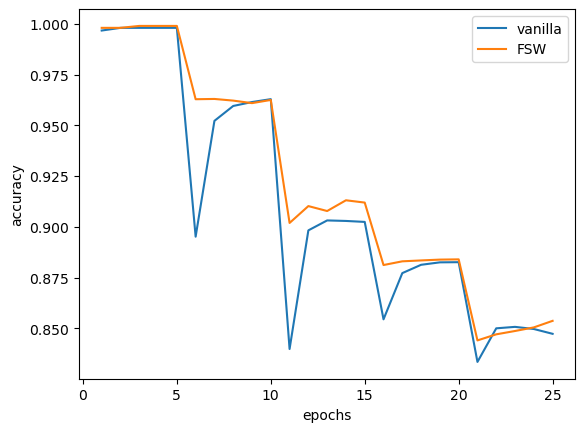

In [15]:
x = np.arange(1, epoch*num_task+1)

plt.plot(x, vanilla_acc_array, label = "vanilla")
plt.plot(x, FSW_acc_array, label = "FSW")

plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')

plt.show()

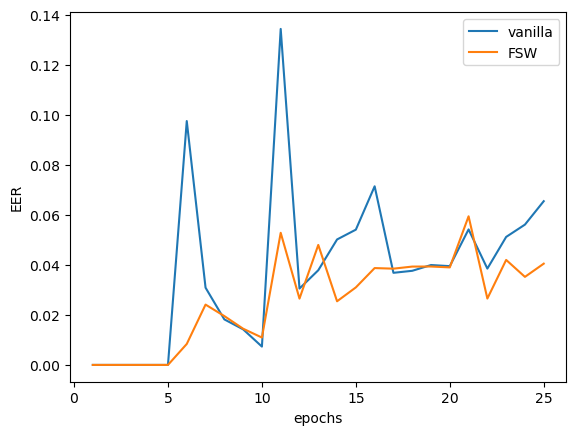

In [16]:
x = np.arange(1, epoch*num_task+1)

plt.plot(x, vanilla_eer_array, label = "vanilla")
plt.plot(x, FSW_eer_array, label = "FSW")

plt.legend()
plt.xlabel('epochs')
plt.ylabel('EER')

plt.show()

In [17]:
np.mean(FSW_eer_array)

0.026373171763858293

In [18]:
np.mean(vanilla_eer_array)

0.03861224411178519